### About This Dataset

## USA Firm Sales Data

The data contains monthly sales (in million USD) of a leading processed food manufacturer in USA. Data for 3 business units, from February 2015 to January 2018, is provided in the same file. 


In [46]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import pickle
import joblib
from datetime import datetime

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set the working directory
import os

os.chdir(r"C:\Users\willi\GitHub\TS_Sales_Prediction_PY\data\raw")

### Import Data

In [29]:
salesdata = pd.read_csv("USA FIRM SALES DATA.csv")

print("✅ Data loaded successfully")

✅ Data loaded successfully


In [30]:
# Check Structure of the Data
salesdata.info()

print(salesdata.head(5))

print(salesdata.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    35 non-null     int64  
 1   Month   35 non-null     object 
 2   BU1     35 non-null     float64
 3   BU2     35 non-null     float64
 4   BU3     35 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.5+ KB
   Year     Month    BU1    BU2    BU3
0  2015  February  125.1  115.5  113.8
1  2015     March  123.6  115.7  113.8
2  2015     April  123.1  116.5  114.0
3  2015       May  123.1  117.7  114.1
4  2015      June  123.4  118.3  114.7
    Year      Month    BU1    BU2    BU3
30  2017     August  133.7  129.4  125.3
31  2017  September  135.2  128.8  125.5
32  2017    October  139.0  129.4  125.9
33  2017   November  140.6  129.8  126.8
34  2017   December  139.0  131.0  127.5


In [31]:
# create a datetime index
salesdata['Date'] = pd.to_datetime(salesdata['Year'].astype(str) + '-' + salesdata['Month'], format='%Y-%B')
data = salesdata.set_index('Date').sort_index()
salesdata.set_index('Date', inplace=True)

print(salesdata.head(5))

            Year     Month    BU1    BU2    BU3
Date                                           
2015-02-01  2015  February  125.1  115.5  113.8
2015-03-01  2015     March  123.6  115.7  113.8
2015-04-01  2015     April  123.1  116.5  114.0
2015-05-01  2015       May  123.1  117.7  114.1
2015-06-01  2015      June  123.4  118.3  114.7


### Create Time Series Object

In [32]:
# Step 3: Extract time series for each Business Unit
ts_BU1 = salesdata['BU1']
ts_BU2 = salesdata['BU2']
ts_BU3 = salesdata['BU3']

# Optional: preview first few entries
print("BU1 Sales Data:\n",ts_BU1.head())

BU1 Sales Data:
 Date
2015-02-01    125.1
2015-03-01    123.6
2015-04-01    123.1
2015-05-01    123.1
2015-06-01    123.4
Name: BU1, dtype: float64


#### Time Series Decomposition

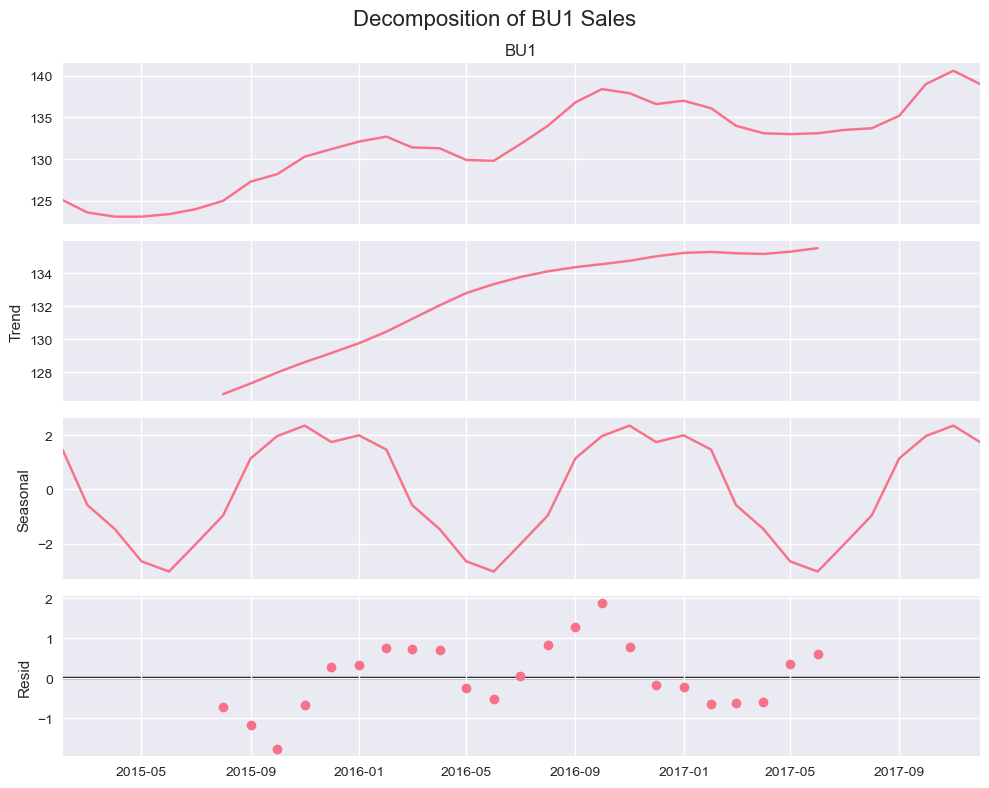

In [33]:
#  Decompose BU1 (assume monthly data, so period=12)
decomp_BU1 = seasonal_decompose(ts_BU1, model='additive', period=12)

# Step 4B: Plot the components
fig = decomp_BU1.plot()
fig.set_size_inches(10, 8)
fig.suptitle('Decomposition of BU1 Sales', fontsize=16)
plt.tight_layout()
plt.show()

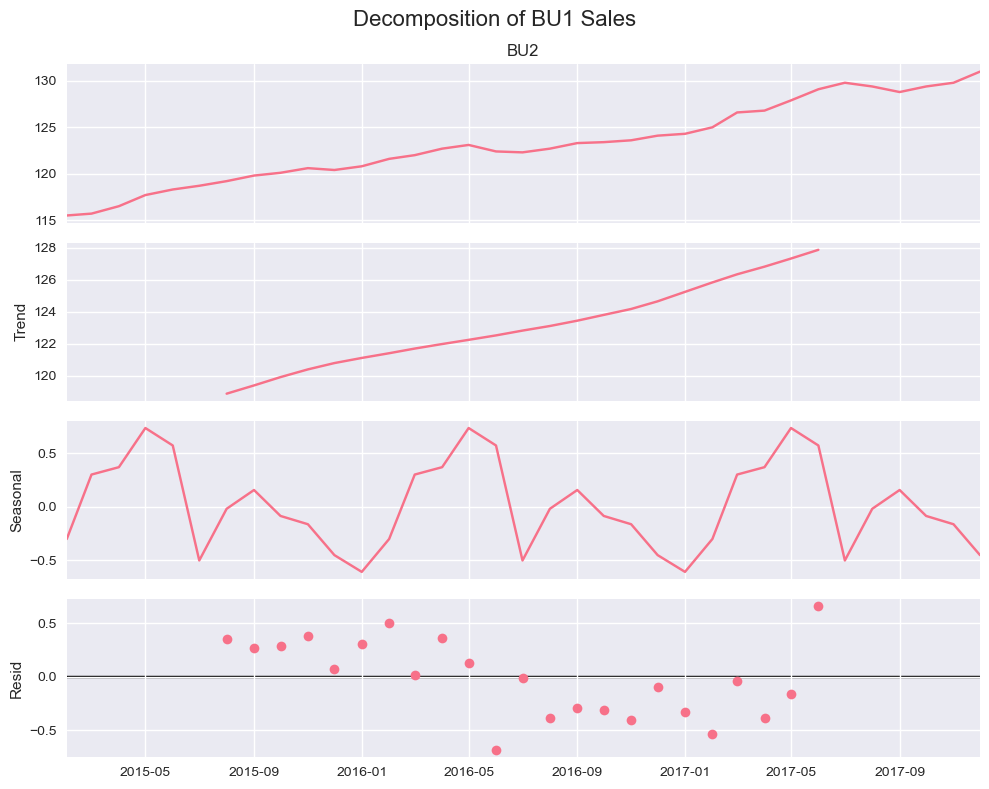

In [34]:
# Decompose BU2 (assume monthly data, so period=12)
decomp_BU2 = seasonal_decompose(ts_BU2, model='additive', period=12)

# Step 4B: Plot the components
fig = decomp_BU2.plot()
fig.set_size_inches(10, 8)
fig.suptitle('Decomposition of BU1 Sales', fontsize=16)
plt.tight_layout()
plt.show()

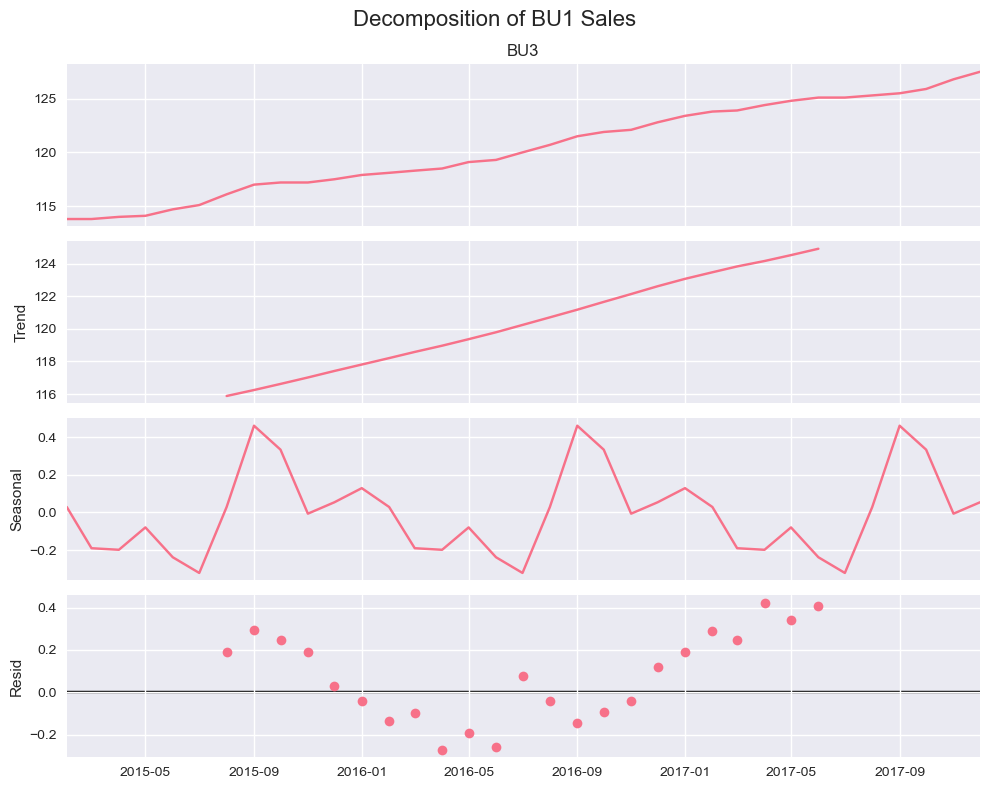

In [35]:
# Decompose BU3 (assume monthly data, so period=12)
decomp_BU3 = seasonal_decompose(ts_BU3, model='additive', period=12)

# Step 4B: Plot the components
fig = decomp_BU3.plot()
fig.set_size_inches(10, 8)
fig.suptitle('Decomposition of BU1 Sales', fontsize=16)
plt.tight_layout()
plt.show()

#### Check for Stationarity

In [36]:
def plot_acf_all(ts_dict, lags=24):
    """
    Plots ACF (correlograms) for multiple time series in one figure.
    
    Parameters:
    - ts_dict: dictionary of time series, e.g., {'BU1': ts1, ...}
    - lags: number of lags to display (default=24)
    """
    fig, axes = plt.subplots(len(ts_dict), 1, figsize=(10, 8))

    for ax, (label, series) in zip(axes, ts_dict.items()):
        plot_acf(series, ax=ax, lags=lags, title=f'ACF Plot - {label}', zero=False)

    plt.tight_layout()
    plt.suptitle("Correlograms (ACF) for BU1, BU2, BU3", fontsize=16, y=1.02)
    plt.show()

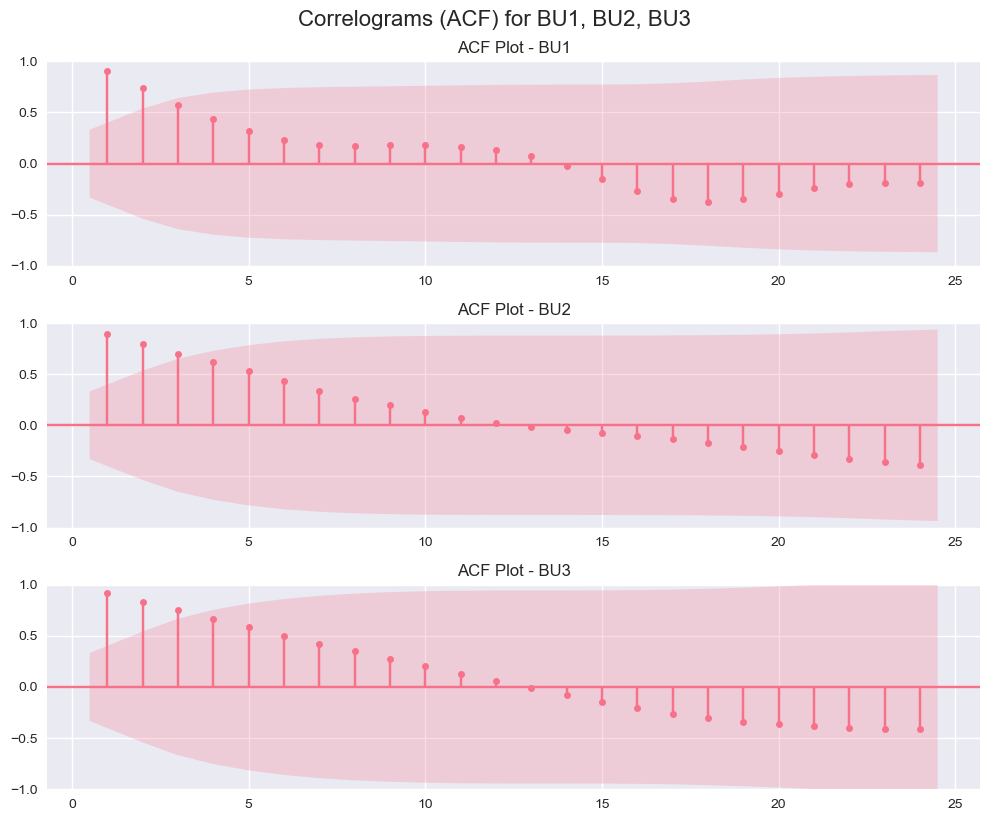

In [37]:
# Create dictionary of time series
ts_dict = {
    'BU1': ts_BU1,
    'BU2': ts_BU2,
    'BU3': ts_BU3
}

# Call the ACF plot function
plot_acf_all(ts_dict)


#### Statistical Stationarity Check (ADF Test)

###### The Augmented Dickey-Fuller test checks for stationarity:

###### Null Hypothesis (H₀): The series is non-stationary

###### Alternative Hypothesis (H₁): The series is stationary

###### We want to reject the null — i.e., get a p-value < 0.05.

In [38]:
def adf_test_all(ts_dict):
    """
    Runs Augmented Dickey-Fuller test on each time series.
    
    Parameters:
    - ts_dict: dictionary of time series like {'BU1': ts1, ...}
    """
    print("📉 Augmented Dickey-Fuller Test Results:\n")
    
    for label, series in ts_dict.items():
        result = adfuller(series.dropna())
        test_stat = result[0]
        p_value = result[1]
        critical_values = result[4]
        
        print(f"🔹 {label}:")
        print(f"   Test Statistic = {test_stat:.4f}")
        print(f"   p-value        = {p_value:.4f}")
        for key, value in critical_values.items():
            print(f"   Critical Value ({key}) = {value:.4f}")
        print("   →", "Stationary ✅" if p_value < 0.05 else "Non-stationary ❌")
        print("-" * 40)

In [39]:
# Dictionary of time series
ts_dict = {
    'BU1': ts_BU1,
    'BU2': ts_BU2,
    'BU3': ts_BU3
}

# Run ADF test on all BUs
adf_test_all(ts_dict)


📉 Augmented Dickey-Fuller Test Results:

🔹 BU1:
   Test Statistic = -2.4760
   p-value        = 0.1214
   Critical Value (1%) = -3.7377
   Critical Value (5%) = -2.9922
   Critical Value (10%) = -2.6357
   → Non-stationary ❌
----------------------------------------
🔹 BU2:
   Test Statistic = -0.2875
   p-value        = 0.9273
   Critical Value (1%) = -3.6392
   Critical Value (5%) = -2.9512
   Critical Value (10%) = -2.6144
   → Non-stationary ❌
----------------------------------------
🔹 BU3:
   Test Statistic = -0.1352
   p-value        = 0.9458
   Critical Value (1%) = -3.6461
   Critical Value (5%) = -2.9541
   Critical Value (10%) = -2.6160
   → Non-stationary ❌
----------------------------------------


#### Check for Seasonality (ACF + Seasonal Diff)

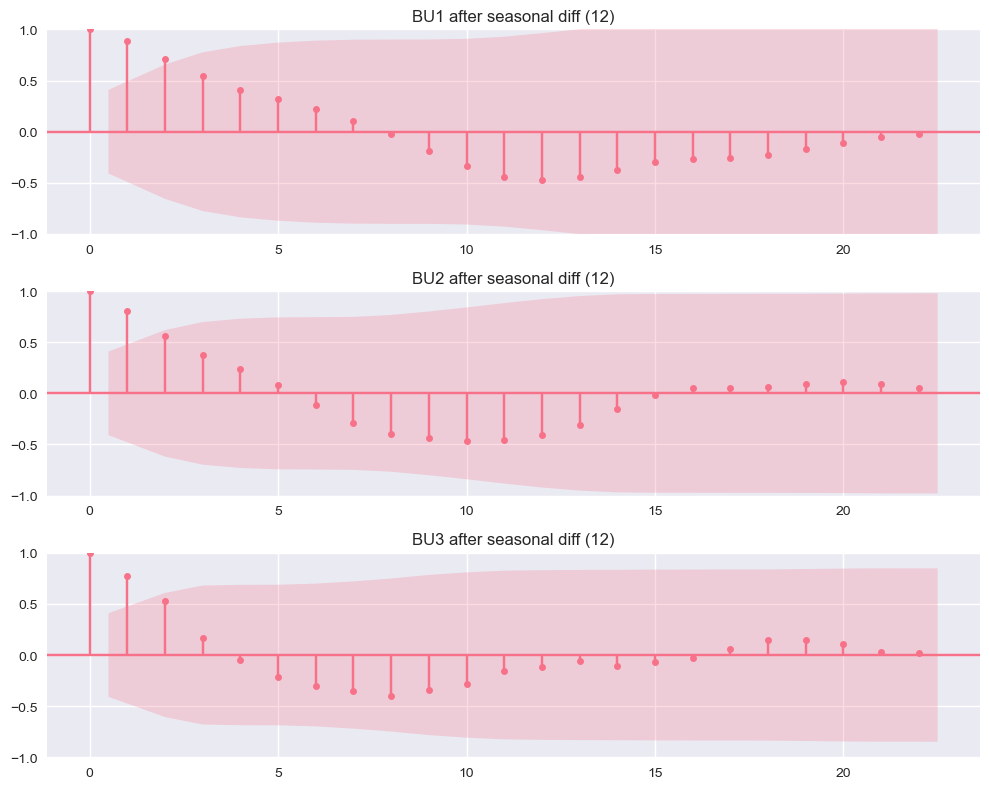

In [41]:

# Create a safe function to plot ACF up to max available lags
def plot_safe_acf(series, ax, title, max_lags=24):
    max_lags = min(len(series) - 1, max_lags)
    plot_acf(series, ax=ax, lags=max_lags, title=title)

# Apply seasonal differencing
seasonal_diff_BU1 = ts_BU1.diff(12).dropna()
seasonal_diff_BU2 = ts_BU2.diff(12).dropna()
seasonal_diff_BU3 = ts_BU3.diff(12).dropna()

# Plot ACFs safely
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
plot_safe_acf(seasonal_diff_BU1, axes[0], "BU1 after seasonal diff (12)")
plot_safe_acf(seasonal_diff_BU2, axes[1], "BU2 after seasonal diff (12)")
plot_safe_acf(seasonal_diff_BU3, axes[2], "BU3 after seasonal diff (12)")
plt.tight_layout()
plt.show()

#### Fit ARIMA Model using `auto_arima`

In [43]:
# Store models for each BU
models = {}

for label, series in ts_dict.items():
    print(f"🔧 Training SARIMA model for {label}...")
    model = auto_arima(
        series,
        seasonal=True,
        m=12,
        D=1,
        stepwise=True,
        suppress_warnings=True,
        trace=True  # Turn this off later for production
    )
    models[label] = model
    print(f"✅ Best SARIMA model for {label}: {model.order} x {model.seasonal_order}\n")

🔧 Training SARIMA model for BU1...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=78.215, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=76.714, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=74.500, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=73.767, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=74.500, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=76.500, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=76.954, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=75.364, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.273 seconds
✅ Best SARIMA model for BU1: (0, 1, 1) x (0, 1, 0, 12)

🔧 Training SARIMA mo

### 3 Month Forecast and Plots of the BUs

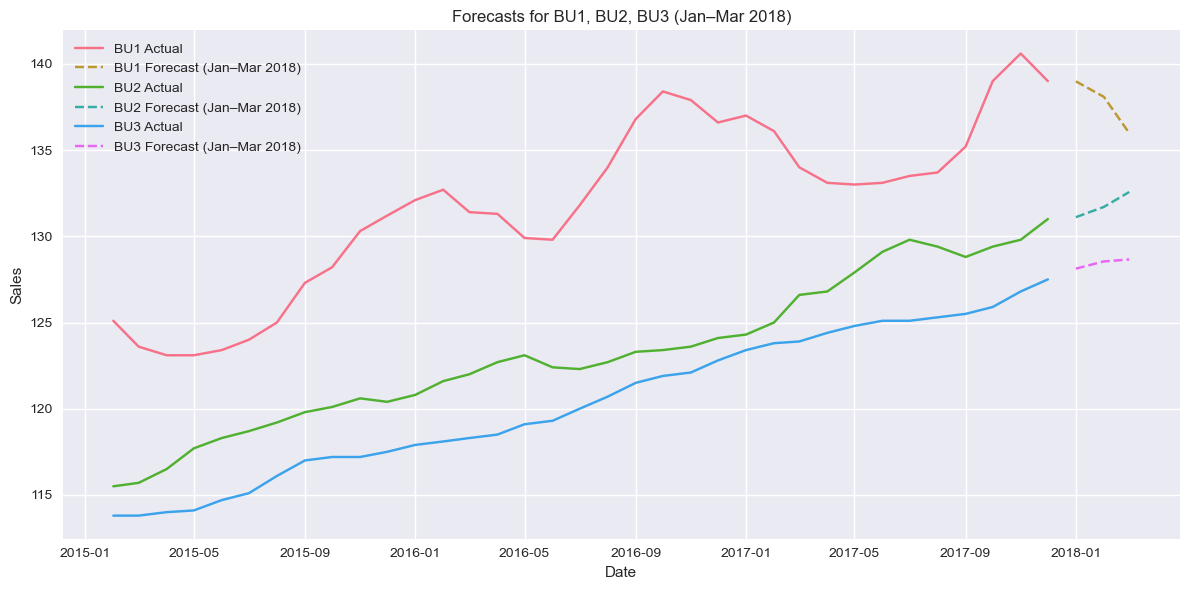

In [44]:
# Step 1: Forecast next 3 periods (Jan–Mar 2018)
n_periods = 3
forecast_dict = {}

for label, model in models.items():
    forecast = model.predict(n_periods=n_periods)
    
    # Generate forecast dates based on last date in original series
    last_date = ts_dict[label].index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='MS')
    
    forecast_series = pd.Series(forecast, index=forecast_dates)
    forecast_dict[label] = forecast_series

# Step 2: Combine into a DataFrame
forecast_df = pd.DataFrame(forecast_dict)

# Step 3: Plot historical + forecast together
plt.figure(figsize=(12, 6))
for label in ts_dict.keys():
    plt.plot(ts_dict[label], label=f'{label} Actual')
    plt.plot(forecast_df[label], '--', label=f'{label} Forecast (Jan–Mar 2018)')

plt.title('Forecasts for BU1, BU2, BU3 (Jan–Mar 2018)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

#### Save Models

In [47]:
# Set the save directory
save_dir = r"C:\Users\willi\GitHub\TS_Sales_Prediction_PY\models"

# Make sure the folder exists
os.makedirs(save_dir, exist_ok=True)

# Save each model
for label, model in models.items():
    file_path = os.path.join(save_dir, f"{label}_sarima_model.pkl")
    joblib.dump(model, file_path)
    print(f"✅ Saved: {label} → {file_path}")

✅ Saved: BU1 → C:\Users\willi\GitHub\TS_Sales_Prediction_PY\models\BU1_sarima_model.pkl
✅ Saved: BU2 → C:\Users\willi\GitHub\TS_Sales_Prediction_PY\models\BU2_sarima_model.pkl
✅ Saved: BU3 → C:\Users\willi\GitHub\TS_Sales_Prediction_PY\models\BU3_sarima_model.pkl
